# Supervised Learning of Actions - Logistic Regression
This note fits a logistic regression model to the sepsis data.

In [57]:
import pandas as pd
import numpy as np
from tqdm import tqdm
exportdir='/data/localhost/taufiq/export-dir/'

In [58]:
import logging
logging.basicConfig(filename='logistic-regression.log', level=logging.INFO)

In [59]:
nra = 5
nr_reps = 1

In [60]:
MIMICtable = pd.read_csv(exportdir + '/MIMIC-1hourly-length-5.csv')
MIMICtable.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance
0,1,65537,7.139723e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.687500,363.888889,0.18,0.18,4020.493550,29.994183,7235.0,3605.0,-3184.512267
1,2,65537,7.139727e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.602564,430.555556,0.00,0.00,4050.487733,515.407667,10760.0,3525.0,-6194.104600
2,3,65537,7.139731e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.751456,402.222222,0.00,0.00,4565.895400,547.876700,14235.0,3475.0,-9121.227900
3,4,65537,7.139734e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804762,275.000000,0.00,0.00,5113.772100,2097.144000,17630.0,3395.0,-10419.083900
4,5,65537,7.139738e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804245,283.000000,0.00,0.00,7210.916100,519.833583,20785.0,3155.0,-13054.250317


In [61]:
#################   Convert training data and compute conversion factors    ######################
logging.info('Processing raw data')
# all 47 columns of interest
colbin = ['gender','mechvent']
colnorm=['age','Weight_kg','HR','SysBP','MeanBP','DiaBP','RR','Temp_C',\
    'Potassium','Sodium','Chloride','Glucose','Calcium',\
    'WBC_count','Arterial_pH','HCO3','Arterial_lactate']
collog=['Creatinine']

MIMICraw = MIMICtable[colbin+colnorm+collog].copy()

for col in MIMICraw:
    if col in colbin:
        MIMICraw[col] = MIMICraw[col] - 0.5
    elif col in colnorm:
        cmu = MIMICraw[col].mean()
        csigma = MIMICraw[col].std()
        MIMICraw[col] = (MIMICraw[col] - cmu)/csigma
    else:
        log_values = np.log(0.1 + MIMICraw[col])
        dmu = log_values.mean()
        dsigma = log_values.std()
        MIMICraw[col] = (log_values - dmu)/dsigma    
logging.info('Raw data processed')

## Include the information for doses taken until time $t$

In [62]:
logging.info('Adding input values to X')

MIMICraw['last_input'] = 0.0
MIMICraw['total_input_before'] = 0.0
MIMICraw['last_vaso_dose'] = 0.0

for index, row in MIMICtable.iterrows():
    if index < len(MIMICtable) - 1 and (MIMICtable.at[index+1,'icustay_id'] == MIMICtable.at[index,'icustay_id']):
        MIMICraw.at[index+1, 'last_input'] = MIMICtable.at[index, 'input_1hourly']
        MIMICraw.at[index+1, 'total_input_before'] = MIMICtable.at[index, 'input_total']
        MIMICraw.at[index+1, 'last_vaso_dose'] = MIMICtable.at[index, 'max_dose_vaso']

def log_normalise(colname):
    global MIMICraw
    log_values = np.log(0.1 + MIMICraw[colname])
    dmu = log_values.mean()
    dsigma = log_values.std()
    MIMICraw[colname] = (log_values - dmu)/dsigma

log_normalise('last_input')
log_normalise('total_input_before')
MIMICraw['last_vaso_dose'] = MIMICraw['last_vaso_dose'] - 0.5

logging.info('Input values added to X')

/homes/taufiq/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [63]:
MIMICraw.to_csv(exportdir + '/MIMICraw-logistic_reg-1hourly-5step.csv', index = False)
MIMICraw.head()

,gender,mechvent,age,Weight_kg,HR,SysBP,MeanBP,DiaBP,RR,Temp_C,...,Glucose,Calcium,WBC_count,Arterial_pH,HCO3,Arterial_lactate,Creatinine,last_input,total_input_before,last_vaso_dose
0,-0.5,-0.5,-0.180877,1.028268,-0.552718,-0.436127,0.135833,0.010776,-1.093381,-0.530683,...,-0.427119,0.737331,-0.084175,-0.310148,-1.164848,0.236777,-0.235148,-0.844613,-1.272434,-0.50
1,-0.5,-0.5,-0.180877,0.684850,-0.912790,-0.207482,0.001679,0.353227,-0.217736,-0.530683,...,0.119360,-0.058891,-0.357865,-0.745042,0.913920,0.236777,-1.241375,0.905418,0.808432,-0.32
2,-0.5,-0.5,-0.180877,0.684850,-0.530560,-0.847687,-0.991054,-0.879596,0.645832,-0.530683,...,-0.294192,0.140165,-0.292179,-0.484105,-0.597911,0.178047,-1.241375,1.776558,0.809891,-0.50
3,-0.5,-0.5,-0.180877,-0.324965,-0.137250,-0.756230,-0.719394,-0.365920,0.854175,-0.327203,...,-0.537892,-0.954640,0.671209,-0.201424,1.102899,0.295507,-0.560111,1.795289,0.833400,-0.50
4,-0.5,-0.5,-0.180877,0.206516,-0.095703,-0.710501,-0.249858,-0.194695,0.808883,0.094294,...,-0.404965,-0.954640,0.671209,-0.092700,0.346983,0.310190,-0.560111,2.206859,0.855642,-0.50


## Create Actions


In [64]:
from sklearn.cluster import KMeans
from scipy.stats import rankdata

logging.info('Creating action bins')
nact = nra**2
input_1hourly_nonzero = MIMICtable.loc[MIMICtable['input_1hourly']>0, 'input_1hourly']
iol_ranked = rankdata(input_1hourly_nonzero)/len(input_1hourly_nonzero) # excludes zero fluid (will be action 1)
iof = np.floor((iol_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
io = np.ones(len(MIMICtable)) # array of ones, by default
io[MIMICtable['input_1hourly']>0] = iof + 1 # where more than zero fluid given: save actual action
vc = MIMICtable['max_dose_vaso'].copy()
vc_nonzero = MIMICtable.loc[MIMICtable['max_dose_vaso']!=0, 'max_dose_vaso']
vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero)
vcf = np.floor((vc_ranked + 0.2499999999)*4) # converts to 4 bins
vcf[vcf==0] = 1
vc[vc!=0] = vcf + 1
vc[vc==0] = 1
# median dose of drug in all bins
ma1 = [MIMICtable.loc[io==1, 'input_1hourly'].median(), MIMICtable.loc[io==2, 'input_1hourly'].median(), MIMICtable.loc[io==3, 'input_1hourly'].median(), MIMICtable.loc[io==4, 'input_1hourly'].median(), MIMICtable.loc[io==5, 'input_1hourly'].median()]
ma2 = [MIMICtable.loc[vc==1, 'max_dose_vaso'].median(), MIMICtable.loc[vc==2, 'max_dose_vaso'].median(), MIMICtable.loc[vc==3, 'max_dose_vaso'].median(), MIMICtable.loc[vc==4, 'max_dose_vaso'].median(), MIMICtable.loc[vc==5, 'max_dose_vaso'].median()]
med = pd.DataFrame(data={'IV':io, 'VC': vc})
med = med.astype({'IV': 'int32', 'VC': 'int32'})
uniqueValues = med.drop_duplicates().reset_index(drop=True)
uniqueValueDoses = pd.DataFrame()
for index, row in uniqueValues.iterrows():
    uniqueValueDoses.at[index, 'IV'], uniqueValueDoses.at[index, 'VC'] = ma1[row['IV']-1], ma2[row['VC']-1]

actionbloc = pd.DataFrame()
for index, row in med.iterrows():
    actionbloc.at[index, 'action_bloc'] = uniqueValues.loc[(uniqueValues['IV'] == row['IV']) & (uniqueValues['VC'] == row['VC'])].index.values[0]+1
actionbloc = actionbloc.astype({'action_bloc':'int32'})

logging.info('Action bins created')

In [65]:
len(actionbloc)

30885

In [66]:
action_count = {}
actions = {}
for index, row in actionbloc.iterrows():
    if (index+1)% 5 == 0:
        if key in action_count:
            action_count[key] += 1
        else:
            action_count[key] = 1
        actions[MIMICtable.at[index, 'icustay_id']] = key
        key = str(row['action_bloc'])+','
    elif index == 0:
        key = str(row['action_bloc'])+','
    else:
        key += str(row['action_bloc'])+','

In [67]:
actions_list = list(action_count.keys())
for idx, at in actions.items():
    actions[idx] = actions_list.index(at)

In [68]:
actionbloc_5step = pd.DataFrame(columns=['action_bloc'], data=list(actions.values()))
actionbloc_5step.head()

,action_bloc
0,0
1,1
2,2
3,3
4,4


## Fitting models

In [69]:
MIMICtable_t0 = MIMICtable[MIMICtable['bloc']==1].reset_index(drop=True)

In [70]:
len(MIMICtable_t0)

6177

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from scipy.stats import rankdata

icuuniqueids = MIMICtable['icustay_id'].unique()
modelsDf = pd.DataFrame()

logging.info('Fitting models')

for model in tqdm(range(nr_reps)):
    logging.info('Model: ' + str(model))
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = MIMICraw.loc[(MIMICtable['icustay_id'].isin(trainidx)) & (MIMICtable['bloc'] == 1)]
    
    prop=0.25
    sample = X[np.floor(np.random.rand(len(X))+prop) == 1]
    kmeans = KMeans(n_clusters=300, random_state=0).fit(sample)
    idx = kmeans.predict(X)
    
    Xtestmimic = MIMICraw[(MIMICtable['icustay_id'].isin(testidx)) & (MIMICtable['bloc'] == 1)]
    Y = actionbloc_5step.loc[MIMICtable_t0['icustay_id'].isin(trainidx), 'action_bloc']
    Ytest = actionbloc_5step.loc[MIMICtable_t0['icustay_id'].isin(testidx), 'action_bloc']
    clf = LogisticRegression(random_state=0, max_iter=100000).fit(X, Y)
    acc_train = clf.score(X, Y)
    acc_test = clf.score(Xtestmimic, Ytest)
    modelsDf = modelsDf.append({'model': model, 'regressor': clf, 'acc_train': acc_train, 'acc_test': acc_test}, ignore_index=True)
logging.info('Model fitting done!')

100%|██████████| 1/1 [01:35<00:00, 95.28s/it]


In [126]:
modelsDf

,acc_test,acc_train,model,regressor
0,0.06183,0.196213,0.0,"LogisticRegression(C=1.0, class_weight=None, d..."


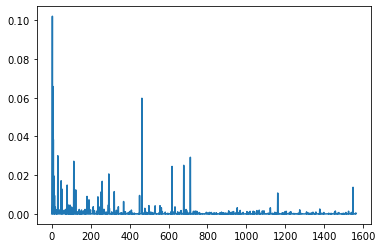

In [127]:
import matplotlib.pyplot as plt
plt.plot(clf.predict_proba(Xtestmimic)[0])

In [128]:
import pickle
filename = '/data/localhost/taufiq/export-dir/logistic-reg-fitted'
pickle.dump(model, open(filename, 'wb'))

In [129]:
# actions = pd.concat([MIMICtable, actionbloc],axis=1)

In [130]:
MIMICraw_t0 = MIMICraw[MIMICtable['bloc']==1].reset_index(drop=True)
MIMICt0 = MIMICtable[MIMICtable['bloc']==1].reset_index(drop=True)

In [131]:
probs = pd.DataFrame()
for idx in testidx:
    X = MIMICraw_t0.loc[MIMICt0['icustay_id']==idx]
    a = actionbloc_5step.loc[MIMICt0['icustay_id']==idx, 'action_bloc'].values[0]
    if a > len(clf.predict_proba(X)[0])-1:
        prob = 0
    else:
        prob = clf.predict_proba(X)[0][a]
    probs = probs.append({'icustay_id': idx, 'action': a, 'prob': prob, 'group_id': kmeans.predict(X)[0]}, ignore_index=True)

In [132]:
probs.head()

,action,group_id,icustay_id,prob
0,3.0,2.0,98314.0,0.102098
1,7.0,3.0,32796.0,0.015911
2,13.0,8.0,65594.0,0.000203
3,16.0,209.0,32844.0,0.006125
4,17.0,29.0,98383.0,0.000271


In [133]:
ids = kmeans.predict(MIMICraw_t0)
group_ids = pd.DataFrame(data=ids, columns=['group_id'])
MIMICt0['group_id']= group_ids['group_id']
MIMICt0.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance,group_id
0,1,65537,7.139723e+09,0.0,22799.404780,4.0,1.0,0.0,0.0,0.0,...,0.687500,363.888889,0.18,0.18,4020.49355,29.994183,7235.0,3605.0,-3184.512267,6
1,1,3,7.245400e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.663900,599.999991,0.00,0.00,6267.00000,0.000000,9490.0,4705.0,-3223.000000,41
2,1,65544,7.056917e+09,0.0,24000.436400,3.0,0.0,0.0,0.0,0.0,...,0.770925,938.636364,0.00,0.00,11332.00000,0.000000,8210.0,4105.0,3122.000000,102
3,1,98314,4.762714e+09,0.0,23940.093773,4.0,0.0,1.0,1.0,1.0,...,0.906504,287.500000,0.00,0.00,0.00000,0.000000,14490.0,7245.0,-14490.000000,2
4,1,14,4.264269e+09,0.0,30946.970000,2.0,0.0,0.0,0.0,1.0,...,0.647399,577.499991,0.00,0.00,0.00000,80.000000,1263.0,599.0,-1183.000000,230


In [134]:
MIMICtable_t4 = MIMICtable[MIMICtable['bloc']==5].reset_index(drop=True)
MIMICtable_t4['group_id']= group_ids['group_id']
MIMICtable_t4.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance,group_id
0,5,65537,7.139738e+09,0.0,22799.404780,4.0,1.0,0.0,0.0,0.0,...,0.804245,283.000000,0.0,0.0,7210.9161,519.833583,20785.0,3155.0,-13054.250317,6
1,5,3,7.245414e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.645714,497.499993,0.0,0.0,6317.0000,20.000000,27050.0,4205.0,-20713.000000,41
2,5,65544,7.056931e+09,0.0,24000.436400,3.0,0.0,0.0,0.0,0.0,...,0.715232,1175.000000,0.0,0.0,11332.0000,0.000000,24630.0,4105.0,-13298.000000,102
3,5,98314,4.762728e+09,0.0,23940.093773,4.0,0.0,1.0,1.0,1.0,...,0.869497,323.750000,0.1,0.1,0.0000,1876.651250,43130.0,6905.0,-41253.348750,2
4,5,14,4.264284e+09,0.0,30946.970000,2.0,0.0,0.0,0.0,1.0,...,0.554667,447.499993,0.0,0.0,1300.0000,80.000000,3399.0,464.0,-2019.000000,230


In [135]:
grouped_info = MIMICtable_t4.groupby('group_id').max()
grouped_info.to_csv("/data/localhost/taufiq/export-dir/grouped_max.csv")
grouped_info = MIMICtable_t4.groupby('group_id').min()
grouped_info.to_csv("/data/localhost/taufiq/export-dir/grouped_min.csv")

In [136]:
probs.to_csv("/data/localhost/taufiq/export-dir/probability-data-5step.csv")